In [86]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\users\riddhi\appdata\local\programs\python\python38\python.exe -m pip install --upgrade pip' command.


In [87]:
import cv2

In [88]:
pip install spicy

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\users\riddhi\appdata\local\programs\python\python38\python.exe -m pip install --upgrade pip' command.


In [89]:
pip install scikit-learn

You should consider upgrading via the 'c:\users\riddhi\appdata\local\programs\python\python38\python.exe -m pip install --upgrade pip' command.


In [90]:
pip install matplotlib

You should consider upgrading via the 'c:\users\riddhi\appdata\local\programs\python\python38\python.exe -m pip install --upgrade pip' command.


In [91]:
pip install pandas

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\users\riddhi\appdata\local\programs\python\python38\python.exe -m pip install --upgrade pip' command.


In [92]:
pip install numpy

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\users\riddhi\appdata\local\programs\python\python38\python.exe -m pip install --upgrade pip' command.


In [93]:

# coding: utf-8

import cv2
import numpy as np
import glob
import math
from scipy.spatial import distance
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import metrics

def IrisLocalization(images):
    #convert image to a color image
    target = [cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in images]
    boundary=[] #initialize empty list that will eventually contain all the images with boundaries
    centers=[] #initialize empty list that will contain the centers of the boundary circles
    for img in target:
        
        draw_img=img
        
        # remove noise by blurring the image
        blur = cv2.bilateralFilter(img, 9,75,75)
        img=blur
        
        #estimate the center of pupil
        horizontalProjection = np.mean(img,0);
        verticalProjection = np.mean(img,1);
        center_x=horizontalProjection.argmin()
        center_y=verticalProjection.argmin()
        
        #recalculate of pupil by concentrating on a 120X120 area
        centrecrop_x = img[center_x-60:center_x+60]
        centrecrop_y = img[center_y-60:center_y+60]
        horizontalProjection = np.mean(centrecrop_y,0);
        verticalProjection = np.mean(centrecrop_x,0);
        crop_center_x=horizontalProjection.argmin()
        crop_center_y=verticalProjection.argmin()

        cimg=img.copy()
        cv2.circle(cimg,(crop_center_x,crop_center_y),1,(255,0,0),2)

        #apply Canny edge detector on the masked image
        maskimage = cv2.inRange(img, 0, 70)
        output = cv2.bitwise_and(img, maskimage)
        edged = cv2.Canny(output, 100, 220)
        
        # Apply Hough transform to find potential boundaries of pupil
        circles = cv2.HoughCircles(edged, cv2.HOUGH_GRADIENT, 10, 100)
        
        #define the center of the pupil
        a = (crop_center_x,crop_center_y)
        
        out = img.copy()
        min_dst=math.inf
        for i in circles[0]:
            #find the circle whose center is closest to the approx center found above
            b=(i[0],i[1])
            dst = distance.euclidean(a, b)
            if dst<min_dst:
                min_dst=dst
                k=i
                
        #draw the inner boundary
        cv2.circle(draw_img,  (int(k[0]), int(k[1])), int(k[2]), (255, 0, 0), 3)

        pupil=circles[0][0]
        radius_pupil = int(k[2])
        
        #draw the outer boundary, which is approximately found to be at a distance 53 from the inner boundary 
        cv2.circle(draw_img,  (int(k[0]), int(k[1])), int(radius_pupil+53), (255, 0, 0), 3)
        boundary.append(draw_img)
        centers.append([k[0],k[1],k[2]])
    return boundary,centers


In [94]:

# coding: utf-8
import cv2
import numpy as np
import glob
import math
from scipy.spatial import distance
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import metrics

def IrisNormalization(boundary,centers):
    target = [img for img in boundary]
    normalized=[]
    cent=0
    for img in target:
        #load pupil centers and radius of inner circles
        center_x = centers[cent][0]
        center_y = centers[cent][1]
        radius_pupil=int(centers[cent][2])
        
        iris_radius = 53 # width of space between inner and outer boundary
    
        #define equally spaced interval to iterate over
        nsamples = 360
        samples = np.linspace(0,2*np.pi, nsamples)[:-1]
        polar = np.zeros((iris_radius, nsamples))
        for r in range(iris_radius):
            for theta in samples:
                #get x and y for values on inner boundary
                x = (r+radius_pupil)*np.cos(theta)+center_x
                y = (r+radius_pupil)*np.sin(theta)+center_y
                x=int(x)
                y=int(y)
                try:
                #convert coordinates
                    polar[r][int((theta*nsamples)/(2*np.pi))] = img[y][x]
                except IndexError: #ignores values which lie out of bounds
                    pass
                continue
        res = cv2.resize(polar,(512,64))
        normalized.append(res)
        cent+=1
    return normalized #returns a list of 64x512 normalized images

In [95]:

# coding: utf-8

import cv2
import numpy as np
import glob
import math
from scipy.spatial import distance
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import metrics

#Equalizes the histogram of the image
def ImageEnhancement(normalized):
    enhanced=[]
    for res in normalized:
        res = res.astype(np.uint8)
        im=cv2.equalizeHist(res)
        enhanced.append(im)
    return enhanced

In [96]:
import cv2
import numpy as np
import glob
import math
import scipy
from scipy.spatial import distance
from scipy import signal
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import metrics


#modulating function as defined in paper
def m(x ,y, f):
    val = np.cos(2*np.pi*f*math.sqrt(x **2 + y**2))
    return val
#spatial filter as defined in paper
def gabor(x, y, dx, dy, f):
    gb = (1/(2*math.pi*dx*dy))*np.exp(-0.5*(x**2 / dx**2 + y**2 / dy**2)) * m(x, y, f)
    return gb

#function to calculate spatial filter over 8x8 blocks
def spatial(f,dx,dy):
    sfilter=np.zeros((8,8))
    for i in range(8):
        for j in range(8):
            sfilter[i,j]=gabor((-4+j),(-4+i),dx,dy,f)
    return sfilter

def get_vec(convolvedtrain1,convolvedtrain2):
    feature_vec=[]
    for i in range(6):
            for j in range(64):
                #Run 8 by 8 filtered block iteratively over the entire image
                start_height = i*8
                end_height = start_height+8
                start_wid = j*8
                end_wid = start_wid+8
                grid1 = convolvedtrain1[start_height:end_height, start_wid:end_wid]
                grid2 = convolvedtrain2[start_height:end_height, start_wid:end_wid]

                # Channel 1
                absolute = np.absolute(grid1)
                # mean
                mean = np.mean(absolute)
                feature_vec.append(mean)
                #deviation
                std = np.mean(np.absolute(absolute-mean))
                feature_vec.append(std)

                # Channel 2
                absolute = np.absolute(grid2)
                # mean
                mean = np.mean(absolute)
                feature_vec.append(mean)
                #deviation
                std = np.mean(np.absolute(absolute-mean))
                feature_vec.append(std)

    return feature_vec

def FeatureExtraction(enhanced):
    con1=[]
    con2=[]
    #get spatial filters
    filter1=spatial(0.67,3,1.5)
    filter2=spatial(0.67,4,1.5) 
    
    feature_vector=[]
    
    for i in range(len(enhanced)):
        img=enhanced[i]
        #define a 48x512 region over which the filters are applied
        img_roi=img[:48,:]
        
        filtered1=scipy.signal.convolve2d(img_roi,filter1,mode='same')
        filtered2=scipy.signal.convolve2d(img_roi,filter2,mode='same')
        
        con1.append(filtered1)
        con2.append(filtered2)
        fv=get_vec(filtered1,filtered2)
        feature_vector.append(fv)
    return feature_vector #each feature vector has a dimension of 1536

In [142]:
# coding: utf-8

import cv2
import numpy as np
import glob
import math
from scipy.spatial import distance
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import metrics

def dim_reduction(feature_vector_train,feature_vector_test,components):
    '''TRAINING'''
    ft_train=feature_vector_train
    
    #get the classes of all training feature vectors
    y_train=[]
    for i in range(0,108):
        for k in range(0,3):
            y_train.append(i+1)
    #y_train=[5,5,5]
    y_train=np.array(y_train)
    
    '''print("h")
    print(ft_train)
    print("j")
    print(y_train)'''
    #fit the LDA model on training data with n components
    sklearn_lda = LDA(n_components=components)
    sklearn_lda.fit(ft_train,y_train)
    
    #transform the traning data
    red_train=sklearn_lda.transform(ft_train)
    
    '''TESTING'''
    ft_test=feature_vector_test
    
    #transform the testing data
    red_test=sklearn_lda.transform(ft_test)
    
    
    #get a list of predicted values for the testing data to calculate ROC
    y_pred=sklearn_lda.predict(ft_test)
    print("red train")
    print(red_train)
    for x in red_train:
        print(len(x))
    print("red test")
    print(red_test)
    for x in red_test:
        print(len(x))
    #return transformed training and testing data, and the testing classes and predicted values for ROC
    return red_train,red_test


def IrisMatching(feature_vector_train,feature_vector_test,components,flag):
    
    #if flag is 1, we do not need to reduce dimesionality otherwise we call the dim_reduction function
    if flag==1:
        red_train=feature_vector_train
        red_test=feature_vector_test
        
    elif flag==0:
        red_train,red_test=dim_reduction(feature_vector_train,feature_vector_test,components)


    arr_f=red_test #test
    arr_fi=red_train #train
    
    index_L1=[]
    index_L2=[]
    index_cosine=[]
    min_cosine=[]
    
    #this loop iterates over each test image
    for i in range(0,len(arr_f)):
        L1=[]
        L2=[]
        Cosine=[]
        
        #this loop iterates over every training image - to be compared to each test image
        for j in range(0,len(arr_fi)):
            f=arr_f[i]
            fi=arr_fi[j]
            sumL1=0 #L1 distance
            sumL2=0 #L2 distance
            sumcos1=0
            sumcos2=0
            cosinedist=0 #cosine distance
            
            #calculate L1 and L2 using the formulas in the paper
            for l in range(0,len(f)):
                sumL1+=abs(f[l]-fi[l])
                sumL2+=math.pow((f[l]-fi[l]),2)
            
            
            #calculate sum of squares of all features for cosine distance
            for k in range(0,len(f)):
                sumcos1+=math.pow(f[k],2)
                sumcos2+=math.pow(fi[k],2)
                
            
            #calculate cosine distance using sumcos1 and sumcos2 calculated above
            cosinedist=1-((np.matmul(np.transpose(f),fi))/(math.pow(sumcos1,0.5)*math.pow(sumcos2,0.5)))
            
            L1.append(sumL1)
            L2.append(sumL2)
            Cosine.append(cosinedist)
        #get minimum values for L1 L2 and cosine distance for each test image and store their index
        index_L1.append(L1.index(min(L1)))
        index_L2.append(L2.index(min(L2)))
        index_cosine.append(Cosine.index(min(Cosine)))
        min_cosine.append(min(Cosine))
        '''print("index")
        print(index_L1)
        print(index_L2)
        print(index_cosine)
        print(min_cosine)'''
        
        
    match=0
    count=0
    
    #stores final matching - correct(1) or incorrect (0)
    match_L1=[]
    match_L2=[]
    match_cosine=[]
    match_cosine_ROC=[]
    
    #calculating matching of the test set according to the ROC thresholds
    thresh=[0.4,0.5,0.6]
    
    for x in range(0,len(thresh)):
        match_ROC=[]
        for y in range(0,len(min_cosine)):
            if min_cosine[y]<=thresh[x]:
                match_ROC.append(1)
            else:
                match_ROC.append(0)
        match_cosine_ROC.append(match_ROC)
        
    
    for k in range(0,len(index_L1)):
        '''count goes from 0 to 3 because we compare the indexes obtained for the first 4 images of the test data
        to the indexes of the first 3 images of 
        the train data (for which match is incremented by 3 everytime count exceeds the value of 3)'''
        if count<4:
            count+=1
        else:
            match+=3
            count=1
            
        '''check if matching is done correctly (1) or not (0) for L1 L2 and cosine distance and accordingly update
        the arrays match_L1,match_L2,match_cosine'''
        if index_L1[k] in range(match,match+3):
                match_L1.append(1)
        else:
            match_L1.append(0)
        if index_L2[k] in range(match,match+3):
            match_L2.append(1)
        else:
            match_L2.append(0)
        if index_cosine[k] in range(match,match+3):
            match_cosine.append(1)
        else:
            match_cosine.append(0)
    #reuturns the matching arrays, and test calsses and predicted values to calculate ROC
    '''print("match")
    print(match_L1)
    print(match_L2)
    print(match_cosine)'''
    
    return match_L1,match_L2,match_cosine,match_cosine_ROC



In [143]:

# coding: utf-8

import cv2
import numpy as np
import glob
import math
from scipy.spatial import distance
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import metrics

def PerformanceEvaluation(match_L1,match_L2,match_cosine):
    
    #storing only those elements that are correctly matched
    correct_L1 = [l for l in match_L1 if l==1]
    correct_L2 = [l for l in match_L2 if l==1]
    correct_cosine = [l for l in match_cosine if l==1]
    
    
    #calculating the correct recognition rates for L1,L2 and cosine similarity
    crr_L1=len(correct_L1)/len(match_L1)
    crr_L2=len(correct_L2)/len(match_L2)
    crr_cosine=len(correct_cosine)/len(match_cosine)
    
    
    return crr_L1*100,crr_L2*100,crr_cosine*100 #return CRR percentages

Training data processed.
Testing data processed.
324
1
Begin Matching test data with the train data
red train
[[ 3.0196823  -2.03586519 -1.03041544 ...  0.67682029 -0.21335647
   1.28498925]
 [ 3.75748472 -1.5106926   0.62197665 ... -0.87660757 -1.85000935
  -0.26154859]
 [ 3.89266209 -2.14862348 -3.34923802 ...  0.77417215 -0.26106516
  -0.37977739]
 ...
 [ 0.06991168 -0.63240901  1.76356652 ...  3.29267912  0.56692796
   0.39766363]
 [-0.26698054 -1.75571699  2.51538463 ...  3.8821659   1.00788136
   1.01858085]
 [-1.10309876 -0.7515048   3.12271942 ...  3.87216616  2.1676859
   0.3532602 ]]
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10


red train
[[ 3.0196823  -2.03586519 -1.03041544 ...  0.49575648 -0.68221499
  -0.20071566]
 [ 3.75748472 -1.5106926   0.62197665 ...  0.85682399  0.10930754
   0.25140709]
 [ 3.89266209 -2.14862348 -3.34923802 ...  0.52326378  1.8737277
   0.20945303]
 ...
 [ 0.06991168 -0.63240901  1.76356652 ...  0.10809377  0.72369576
  -0.22255694]
 [-0.26698054 -1.75571699  2.51538463 ...  0.03912005 -0.19073104
  -0.16105901]
 [-1.10309876 -0.7515048   3.12271942 ... -1.11348264 -0.81409933
   0.52056813]]
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
9

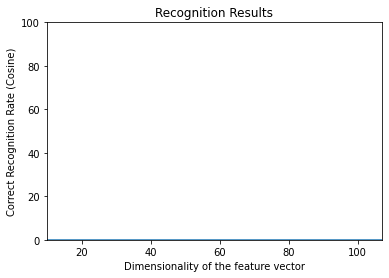

'\nmlkm\n#Calculating the false positive and the true positive rates for the data\n#We have taken match_cosine[5] because the 5th instance of the array is for the 107 reduced feature dimension\nfmr_all=[]\nfnmr_all=[]\n\nfor q in range(0,3):\n    false_accept=0\n    false_reject=0\n    num_1=len([i for i in match_cosine_ROC[5][q] if i==1])\n    num_0=len([i for i in match_cosine_ROC[5][q] if i==0])\n\n    for p in range(0,len(match_cosine[5])):\n        if match_cosine[5][p]==0 and match_cosine_ROC[5][q][p]==1:\n            false_accept+=1\n        if match_cosine[5][p]==1 and match_cosine_ROC[5][q][p]==0:\n            false_reject+=1\n    fmr=false_accept/num_1\n    fnmr=false_reject/num_0\n    thresh=[0.4,0.5,0.6]\n    fmr_all.append(fmr)\n    fnmr_all.append(fnmr)\n\n\ndict1={\'Threshold\':thresh,\'FMR\':fmr_all,\'FNMR\':fnmr_all}\nroc_table=pd.DataFrame(dict1)\nprint("ROC Measures : \n")\nprint(roc_table.iloc[0],"\n")\nprint(roc_table.iloc[1],"\n")\nprint(roc_table.iloc[2])\n\n\n#P

In [144]:

# coding: utf-8

import cv2
import numpy as np
import glob
import math
import scipy
from scipy.spatial import distance
from scipy import signal
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import metrics
"""from IrisLocalization import IrisLocalization
from IrisNormalization import IrisNormalization
from ImageEnhancement import ImageEnhancement
from FeatureExtraction import FeatureExtraction
from IrisMatching import IrisMatching
from PerformanceEvaluation import PerformanceEvaluation"""
import warnings
warnings.filterwarnings("ignore")

'''TRAINING'''
#reading the training images from the CASIA dataset

images_train = [cv2.imread(file) for file in sorted(glob.glob('D:/College/BE project/Dataset/CASIA Iris Image Database (version 1.0)/*/1/*.bmp'))]

#running Localization, Normalization,Enhancement and Feature Extraction on all the training images
boundary_train,centers_train=IrisLocalization(images_train)
normalized_train=IrisNormalization(boundary_train,centers_train)
enhanced_train=ImageEnhancement(normalized_train)
feature_vector_train=FeatureExtraction(enhanced_train)
print("Training data processed.")

#print(images_train)

'''TESTING'''
#reading the testing images from the CASIA dataset
images_test = [cv2.imread(file) for file in sorted(glob.glob('D:/College/BE project/Dataset/CASIA Iris Image Database (version 1.0)/005/2/005_2_3.bmp'))]
#running Localization, Normalization,Enhancement and Feature Extraction on all the testing images
boundary_test,centers_test=IrisLocalization(images_test)
normalized_test=IrisNormalization(boundary_test,centers_test)
enhanced_test=ImageEnhancement(normalized_test)
feature_vector_test=FeatureExtraction(enhanced_test)
print("Testing data processed.")

print(len(feature_vector_train))
print(len(feature_vector_test))

crr_L1=[]
crr_L2=[]
crr_cosine=[]
y_test=[]
y_pred=[]
match_cosine=[]
match_cosine_ROC=[]

#Performing Matching and CRR scores for 10,40,60,80,90,107 number of dimensions in the reduced feature vector
components=[10,40,60,80,90,107]

print("Begin Matching test data with the train data")

for comp in components:
    
    #Running matching for all the dimensions specified in "components" 
    comp_match_L1,comp_match_L2,comp_match_cosine,comp_match_cosine_ROC=IrisMatching(feature_vector_train,feature_vector_test,comp,0)
    
    #Calculating CRR for all the dimensions specified in "components" 
    comp_crr_L1,comp_crr_L2,comp_crr_cosine=PerformanceEvaluation(comp_match_L1,comp_match_L2,comp_match_cosine)
    
    #combining the results of all the dimensional feature vector into one array
    crr_L1.append(comp_crr_L1)
    crr_L2.append(comp_crr_L2)
    crr_cosine.append(comp_crr_cosine)
    match_cosine.append(comp_match_cosine)
    match_cosine_ROC.append(comp_match_cosine_ROC)
    print(comp_match_L1,comp_match_L2,comp_match_cosine,comp_match_cosine_ROC)


#Performing Matching and calculating CRR score for the original feature vector (without dimensionality reduction)
orig_match_L1,orig_match_L2,orig_match_cosine,orig_match_cosine_ROC=IrisMatching(feature_vector_train,feature_vector_test,0,1)
orig_crr_L1,orig_crr_L2,orig_crr_cosine=PerformanceEvaluation(orig_match_L1,orig_match_L2,orig_match_cosine)  
print("Completed Matching")
print(orig_match_L1,orig_match_L2,orig_match_cosine,orig_match_cosine_ROC)

#Table for CRR rates for the original and reduced feature set(components=107)
print('\n\n\n')
dict={'Similarity Measure':['L1','L2','Cosine Distance'],'CRR for Original Feature Set':[orig_crr_L1,orig_crr_L2,orig_crr_cosine],'CRR for Reduced Feature Set (107)':[crr_L1[5],crr_L2[5],crr_cosine[5]]}
table=pd.DataFrame(dict)
print("Recognition results using Different Similarity Measures : \n")
print(table.iloc[0],"\n")
print(table.iloc[1],"\n")
print(table.iloc[2])


# Plotting the incresing CRR for cosine similarity with the incresing dimensionality
plt.plot(components,crr_cosine)
plt.axis([10,107,0,100])
plt.ylabel('Correct Recognition Rate (Cosine)')
plt.xlabel('Dimensionality of the feature vector')
plt.title('Recognition Results')
plt.show()


"""
mlkm
#Calculating the false positive and the true positive rates for the data
#We have taken match_cosine[5] because the 5th instance of the array is for the 107 reduced feature dimension
fmr_all=[]
fnmr_all=[]

for q in range(0,3):
    false_accept=0
    false_reject=0
    num_1=len([i for i in match_cosine_ROC[5][q] if i==1])
    num_0=len([i for i in match_cosine_ROC[5][q] if i==0])

    for p in range(0,len(match_cosine[5])):
        if match_cosine[5][p]==0 and match_cosine_ROC[5][q][p]==1:
            false_accept+=1
        if match_cosine[5][p]==1 and match_cosine_ROC[5][q][p]==0:
            false_reject+=1
    fmr=false_accept/num_1
    fnmr=false_reject/num_0
    thresh=[0.4,0.5,0.6]
    fmr_all.append(fmr)
    fnmr_all.append(fnmr)


dict1={'Threshold':thresh,'FMR':fmr_all,'FNMR':fnmr_all}
roc_table=pd.DataFrame(dict1)
print("ROC Measures : \n")
print(roc_table.iloc[0],"\n")
print(roc_table.iloc[1],"\n")
print(roc_table.iloc[2])


#Plotting the ROC Curve
plt.plot(fnmr_all,fmr_all)
plt.title('ROC Curve')
plt.ylabel('False Non-Match Rate')
plt.xlabel('False Match Rate')
plt.show()
"""